# 연구목표 - 범주형 데이터 이진분류 경진 대회

- 목적
  - 범주형 데이터 23개를 활용
  - 정답 데이터 0 혹은 1을 맞추는 게임
    - 해당 데이터가 정답 1에 속할 확률을 구하는 대회
    - submmission.csv에 예측값(확률)을 넣어서 제출 (kaggle상에 해당 대회사이트)
    - public / private score가 나옴
    - **private score가 실제 등수**

- 특징
  - 모델에 집중하는것보다는, 피처 데이터에 집중하는 피처 엔지니어링이 좀더 중요한 대회
  - 모델의 성능향상은 후처리에서 진행(하이퍼, 교차검증등등)
  - 피처의 의미는 제공(X) -> 인사이트 정보 없음
  - 피처 특징
    - bin_ : 이진 피처(고유값이 2개)
    - nom_ : 범주형(명목형) 피처
    - ord_ : 범주형(순서형) 피처 -> 고유값의 순서가 중요
    - day  : 고유값이 7개 -> 요일
    - month : 고유값이 12개 -> 1월 ~ 12월 
  - 타깃값
    - 범주형
    - 0과 1
    - 이진분류
      - 1(양성)을 예측한 확률을 제출( 정답을 제출할수도 있음)
  - 평가값
    - auc roc

# 데이터 획득

- 원래 캐글대회는 캐글 제공 노트에서 진행하면 데이터를 바로 세팅해서 제공해줌
- 여기서는 코랩에서 진행하고 캐글에 제출하는 방식을 취하겟다

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# 데이터 경로 path
data_path = '/content/drive/MyDrive/cloud_ai/share/3.머신러닝/res/Q1/'

# DF로 구성 -> 확인 결과 id 컬럼은 인덱스정도 의미임 
# -> 특정 컬럼을 인덱스 지정후로드
train      = pd.read_csv( data_path+'train.csv', index_col='id')
test       = pd.read_csv( data_path+'test.csv', index_col='id')
submission = pd.read_csv( data_path+'sample_submission.csv', index_col='id')

train.head(2)

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,...,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0
1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,...,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0


In [196]:
submission.shape

(200000, 1)

In [3]:
train.head(2).T

id,0,1
bin_0,0,0
bin_1,0,1
bin_2,0,0
bin_3,T,T
bin_4,Y,Y
nom_0,Green,Green
nom_1,Triangle,Trapezoid
nom_2,Snake,Hamster
nom_3,Finland,Russia
nom_4,Bassoon,Piano


In [4]:
train.shape, test.shape, submission.shape

((300000, 24), (200000, 23), (200000, 1))

In [5]:
test.head(1)

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
id,,,,,,,,,,,,,,,,,,,,,
300000,0,0,1,T,Y,Blue,Triangle,Axolotl,Finland,Piano,...,9d117320c,3c49b42b8,2,Novice,Warm,j,P,be,5,11


## 파악한 내용
1. test 데이터를 예측해서 submission의 target 컬럼에 채운다
  - id값이 동일, shape상 데이터개수 동일
2. 기본값으로 모두 0.5로 세팅, 확률 -> predict_proba()[:, 1]

In [6]:
# 1. test 데이터를 예측해서 submission의 target 컬럼에 채운다
# 2. 기본값으로 모두 0.5로 세팅, 확률 -> predict_proba()[:, 1]
submission.head(), submission.target.unique()

(        target
 id            
 300000     0.5
 300001     0.5
 300002     0.5
 300003     0.5
 300004     0.5, array([0.5]))

# 데이터 준비 + EDA (분석, 피처엔지니어링 대상및 처리내용 체크)

## 피처 요약 함수 구성 - 차후 계속 사용(업그레이드)

In [79]:
def summary_feature_info( df, train=train ):
    '''
      # 피처 요약 정보 생성하는 함수 구성 -> 피처를 빠르게 파악할수 있다
      # 전체 데이터 : 볼륨(형상) -> print()
      # 피처별 : 피처명, 타입,  결측치수, 고유값수, 샘플값0~2(0,1,2개정도) => DF로 구성 출력
      # 피처를 파악해 보겠다
    '''
    sum_df = pd.DataFrame( train.dtypes, columns=['type'])   
    # 인덱스 -> 컬럼으로 이동
    sum_df = sum_df.reset_index()
    # 컬럼명 index -> feature_name 변경
    sum_df.rename( columns={ 'index':'feature_name' }, inplace=True)

    # 결측치수
    sum_df['결측치수'] = train.isnull().sum().values

    # 고유값수
    sum_df['고유값수'] = train.nunique().values

    # 샘플값0~2(0,1,2개정도)
    sum_df['샘플값0'] = train.loc[0].values
    sum_df['샘플값1'] = train.loc[1].values
    sum_df['샘플값2'] = train.loc[2].values

    return sum_df

summary_df = summary_feature_info( train )
summary_df

,feature_name,type,결측치수,고유값수,샘플값0,샘플값1,샘플값2
0,bin_0,int64,0,2,0,0,0
1,bin_1,int64,0,2,0,1,0
2,bin_2,int64,0,2,0,0,0
3,bin_3,int64,0,2,1,1,0
4,bin_4,int64,0,2,1,1,1
5,nom_0,object,0,3,Green,Green,Blue
6,nom_1,object,0,6,Triangle,Trapezoid,Trapezoid
7,nom_2,object,0,6,Snake,Hamster,Lion
8,nom_3,object,0,6,Finland,Russia,Russia
9,nom_4,object,0,4,Bassoon,Piano,Theremin


In [8]:
# 피처별 결측 개수 구하기
train.isnull().sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [9]:
# 피처별 고유값 개수 구하기
train.nunique().values

array([    2,     2,     2,     2,     2,     3,     6,     6,     6,
           4,   222,   522,  1220,  2215, 11981,     3,     5,     6,
          15,    26,   192,     7,    12,     2])

In [10]:
train.loc[0].values

array([0, 0, 0, 'T', 'Y', 'Green', 'Triangle', 'Snake', 'Finland',
       'Bassoon', '50f116bcf', '3ac1b8814', '68f6ad3e9', 'c389000ab',
       '2f4cb3d51', 2, 'Grandmaster', 'Cold', 'h', 'D', 'kr', 2, 2, 0],
      dtype=object)

## 피처 요약 기준 해석및 전략 수립

### bin_xxx (이진형)

In [11]:
# 관련 피처만 출력
summary_df.loc[ :4 ]
# 고유값은 각각 2개씩 => 이진형 OK
# 샘플값 확인 결과 bin_3, bin_4 은 인코딩(문자->수치) 처리 필요 -> 학습데이터가 될수 있다

,feature_name,type,결측치수,고유값수,샘플값0,샘플값1,샘플값2
0,bin_0,int64,0,2,0,0,0
1,bin_1,int64,0,2,0,1,0
2,bin_2,int64,0,2,0,0,0
3,bin_3,object,0,2,T,T,F
4,bin_4,object,0,2,Y,Y,Y


In [12]:
# 실제 고유값 확인
for i in range(5):
  feature_name = f'bin_{i}'
  print( f'{feature_name} 의 고유값 : { train[feature_name].unique() }')

# 통상, 양성, 긍정:P,T,Y => 1, 음성, 부정 => 0으로 매칭
# 'T':1, 'F':0, 'Y':1, 'N':0  변환 매칭 테이블

bin_0 의 고유값 : [0 1]
bin_1 의 고유값 : [0 1]
bin_2 의 고유값 : [0 1]
bin_3 의 고유값 : ['T' 'F']
bin_4 의 고유값 : ['Y' 'N']


### nom_xxx (명목형)

In [13]:
# 관련 피처만 출력
summary_df.loc[ 5:5+9 ]
# 고유값 6개 미만은 원-핫 인코딩
# 고유값이 많은 경우, 시각화를 통해서 체크 (사용, 인코딩여부->원-핫)

,feature_name,type,결측치수,고유값수,샘플값0,샘플값1,샘플값2
5,nom_0,object,0,3,Green,Green,Blue
6,nom_1,object,0,6,Triangle,Trapezoid,Trapezoid
7,nom_2,object,0,6,Snake,Hamster,Lion
8,nom_3,object,0,6,Finland,Russia,Russia
9,nom_4,object,0,4,Bassoon,Piano,Theremin
10,nom_5,object,0,222,50f116bcf,b3b4d25d0,3263bdce5
11,nom_6,object,0,522,3ac1b8814,fbcb50fc1,0922e3cb8
12,nom_7,object,0,1220,68f6ad3e9,3b6dd5612,a6a36f527
13,nom_8,object,0,2215,c389000ab,4cd920251,de9c9f684
14,nom_9,object,0,11981,2f4cb3d51,f83c56c21,ae6800dd0


### ord_xxx (순서형)

In [14]:
summary_df.loc[ 15:15+5 ]

# ord_3~5 : 알파벳순 순서 정의

,feature_name,type,결측치수,고유값수,샘플값0,샘플값1,샘플값2
15,ord_0,int64,0,3,2,1,1
16,ord_1,object,0,5,Grandmaster,Grandmaster,Expert
17,ord_2,object,0,6,Cold,Hot,Lava Hot
18,ord_3,object,0,15,h,a,h
19,ord_4,object,0,26,D,A,R
20,ord_5,object,0,192,kr,bF,Jc


In [15]:
for i in range(3):
  feature_name = f'ord_{i}'
  print( f'{feature_name} 의 고유값 : { train[feature_name].unique() }')

# ord_0 : 1 -> 2 -> 3
# ord_1 : Novice -> Contributor -> Expert -> Master -> Grandmaster 
# ord_2 : Freezing -> Cold -> Warm -> Hot -> Boiling Hot -> Lava Hot

ord_0 의 고유값 : [2 1 3]
ord_1 의 고유값 : ['Grandmaster' 'Expert' 'Novice' 'Contributor' 'Master']
ord_2 의 고유값 : ['Cold' 'Hot' 'Lava Hot' 'Boiling Hot' 'Freezing' 'Warm']


### 순환형((주기), day, month), target

In [16]:
print( f'day 의 고유값 :    { train["day"].unique() }')
print( f'month 의 고유값 :  { train["month"].unique() }')
print( f'target 의 고유값 : { train["target"].unique() }')
# day, month 원-핫 인코딩

day 의 고유값 :    [2 7 5 4 3 1 6]
month 의 고유값 :  [ 2  8  1  4 10  3  7  9 12 11  5  6]
target 의 고유값 : [0 1]


## 데이터 시각화를 통한 분석

- 데이터의 불균형도 파악
- 타겟값(1)에 대힌 비율 체크
- 통상적으로 0에 대해 1이 작게 구성되어 있다(제공된 데이터 기준)
- 분포도 통해 확인
  - 정답 값 분포
  - 이진 피처 분포
  - 명목형 피처 분포
  - 순서형 피처 분포
  - 날짜형 피처 분포
- 분포도 처리
  - 수치형
    - displot()
  - **범주형**
    - countplot()

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### 타겟(정답) 값 분포

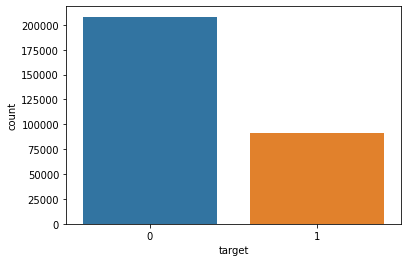

In [18]:
sns.countplot( data=train, x='target' );
# 둘사이에 비율 => 0의개수/1의개수 

In [19]:
# 타겟값 1에 비해 타겟값 0은 2.269배 많이 분포한다 
# -> 범주형변수의 고유값별로 타겟값의 비율을 유지하는가? (어느정도)
c0, c1 = np.unique( train.target.values,  return_counts=True)[1]
c0 / c1

2.2692559173532105

타겟값간 비율 2.2692559173532105


Text(0.5, 1.0, 'Target Value Distribution')

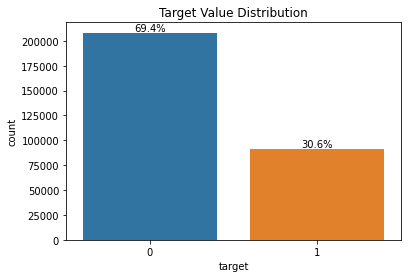

In [20]:
# 향후 시각화 자료에 비율을 표기하는 부분을 추가 => 텍스트 드로잉
def show_text_percent_by_targert( ax, total_count, is_show=True,  ):
  '''
    is_show : True일대만 텍스트가 노출되게 처리
    ax : 텍스트를 그리고자 하는 차트의 축정보
    total_count : 전체 카운트수
  '''
  persents = list()         # 비율을 담는 그릇
  # 카운트 플롯 차트상에 개별 박스 정보를 구하는 방법 -> ax.patches

  # 카운트 플롯 차트상에서 순차적으로 박스를 하나식 추출한다
  for patch in ax.patches: # 차트상에 존재하는 모든 형태의 도형을 차례대로 추출하는 연속형 변수
    w = patch.get_width()  # 타겟값 0 혹은 1, 카운트 플롯의 개별 박스 너비
    h = patch.get_height() # 타겟값 0 혹은 1의 카운트수 -> 카운트 플롯의 개별 박스 높이->카운트
    p = h/total_count * 100 # 타깃값의 비율 = (개별박스의 높이(카운트) / 전체카운트)*100
    persents.append( p )
    # 텍스트 그리기
    # 좌표 정보 획득
    l = patch.get_x()    # 도형 왼쪽 테투리 X축의 기준 위치값    
    ax.text(  x=l + w/2,  # 도형의 정 가운데를 X축 좌표
              y=h + total_count*0.005, # 1, total_count(가변값)의 특정 비율로 올려서 위치를 조정
              s=f'{p:1.1f}%', # 타겟값의 비율을 개별 차트내 도형 위에 그려지는 내용 ex) 38.8%
              ha='center'    # 정렬(가운데)
            )
  if is_show:
    if len(persents) == 2:   # 타겟용
      print( '타겟값간 비율', persents[0]/persents[1] )
    elif len(persents) == 4: # 이진 피처용
      # print( persents )
      # 타겟값에 맞춰서 도형이 그려진다 0번 타겟이 먼저 그려지고, 1번 타겟이 나중에 그려진다
      print( persents[0]/persents[2], persents[1]/persents[3] )
  pass

ax = sns.countplot( data=train, x='target');
show_text_percent_by_targert( ax, train.shape[0] )
ax.set_title('Target Value Distribution')

### bin_xxx (이진 피처)

- 범주형 피처의 고유값별 타겟값 분포 확인
- 특정 타겟값에 특정 고유값이 치우치는지(편향되었는지) 체크

2.2733764366019287 2.2413354800440644


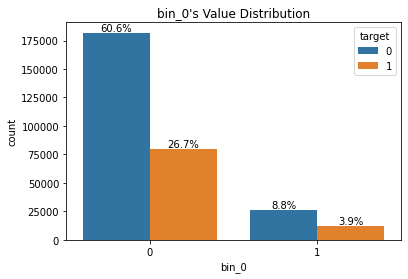

2.030794737986519 3.234433443344334


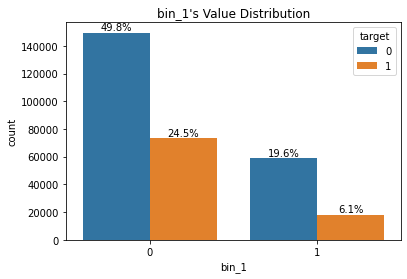

2.3163007437942467 2.196280130112041


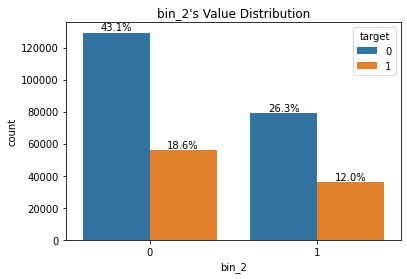

2.3053821313240044 2.2322240367215436


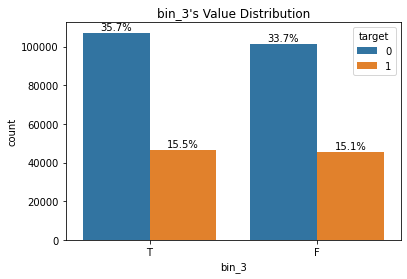

2.44700867000036 1.996046447332043


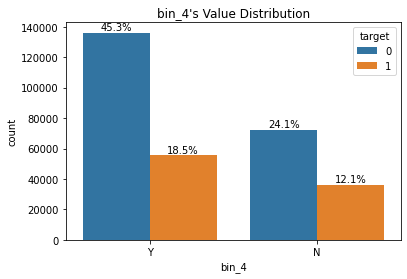

In [21]:
bin_features = [ f'bin_{i}' for i in range(5) ]
for bin_feature in bin_features:

  ax = sns.countplot( data=train, x=bin_feature, hue='target' );
  show_text_percent_by_targert( ax, train.shape[0] )
  ax.set_title(f'{ bin_feature }\'s Value Distribution')
  plt.show()
  #break

# 타겟값 기준 : 2.269
# bin_0의 고유값별 타겟반 분포 비율 : 2.2733764366019287 2.2413354800440644 : 
# 이정도는 비율을 지키고 있다
# bin_1, bin_4에서 고유값별 타겟값 비율이 일정 부분 상이한게 보인다 => 정밀 체크 해보야 겟지만
# 큰 추세상으로는 다르지 않으므로 그대로 전체 피처를 다 사용하겠다

# 대부분 피처는 정답 비율을 유지하고 잇지만, 2개 피처는 유지 하지 않고 있다
# 추세를 벗어난것은 아니다 => 성능을 끌어 올릴대, 3개는 비슷한 유형, 2개는 좀 다른 비율 유형
# 학습시 성능을 끌어 올릴때 단서 조항 사용

### nom_xxx 명목형 피처 분포

- 대상
  - 고유값이 6개 이하 피처만 대상
  - 그 이상은 무의미
    - 원-핫 인코딩 단독
    - 피처 제거 기법
    - 해싱 인코딩을 사용 => 비율 축소 혹은 수치 축소
    - 프리퀀시(빈도) 인코딩 사용 => 비중으로 표현
    - 위의 인코딩 방식 + 원-핫 인코딩 조합
- 차트
  - x축은 피처 -> 고유값이 등장
  - 왼쪽 y축 카운트 
  - 오른쪽 y축 정답 1이 피처의 고유값별로 차지하는 비율
    - 순서형 데이터형 경우에는 개별 피처의 고유값별 비열율을 연결하면 -> 선형 모델이 보인다(추세선이 보임)
  - y축이 2개 -> ax.twinx() :x축공유, y는 오른쪽이 나옴
    - 왼쪽 기준으로는 카운트차트(바형식)
    - 오른쪽 기준으로는 포인트차트(선형식)
  - 절차
    - 데이터 교차 분석표 생성
    - 포인트 플롯 생성 -> 비율의 연결
    - 기존 카운트 플롯 생성 연결 -> 분포


#### 데이터 교차 분석표

- cross-tabulation (교차분석표)
  - 범주형 데이터 2개를 분석할때 사용되는 표
  - 범주형 데이터의 빈도/통계량을 행렬로 결합한 표
  - **명목형 피처 단위의 정답 1에 대한 비율을 표현하기 위해 사용**

In [22]:
pd.crosstab( train['nom_0'], train['target'] )
# 카운트 표현 

target,0,1
nom_0,,
Blue,72914,23252
Green,85682,41659
Red,49640,26853


In [23]:
# 백분율로 표현
# normalize 옵션 지정 => index or column을 지정하면 해당 기준으로 백분율 처리
cross_tab = pd.crosstab( train['nom_0'], train['target'], normalize='index' ) * 100
cross_tab

target,0,1
nom_0,,
Blue,75.820976,24.179024
Green,67.285478,32.714522
Red,64.894827,35.105173


In [24]:
# 인덱스 -> 컬럼으로 이동
cross_tab.reset_index( inplace=True )
cross_tab

# 타겟값 비율에 아래 값들은 전반적으로 유사한 비율을 가지고 있다

target,nom_0,0,1
0,Blue,75.820976,24.179024
1,Green,67.285478,32.714522
2,Red,64.894827,35.105173


In [25]:
# 함수화
def make_cross_tab( df , feature_name ):
  cross_tab = pd.crosstab( df[feature_name], df['target'], normalize='index' ) * 100
  cross_tab.reset_index( inplace=True )
  return cross_tab

cross_tab = make_cross_tab( train, 'nom_0' )
cross_tab

target,nom_0,0,1
0,Blue,75.820976,24.179024
1,Green,67.285478,32.714522
2,Red,64.894827,35.105173


In [26]:
# 타겟값 비율 추출
cross_tab[1]

0    24.179024
1    32.714522
2    35.105173
Name: 1, dtype: float64

#### 포인트 플롯 


- 정답 1에 대한 비율 포인트를 찍고, 포인트를 연결
- 이것을 통해 추세를 확인, **차이 확인(구분이되는가)**

In [28]:
cross_tab.columns

Index(['nom_0', 0, 1], dtype='object', name='target')

In [40]:
def show_pointplot( feature, cross_tab, color, ax=None ):
  if ax:
    sns.pointplot(   x=feature,             # 피처값
                  y=1,            # 정다 1에 대한 포인트 플롯
                  data=cross_tab, # 그리는 대상 df
                  order=cross_tab[feature],     # 포인트플롯 순서
                  color=color,    # 그리는 색상
                  ax=ax
                  );
show_pointplot( 'nom_0', cross_tab, 'blue' )
# nom_0에서 사용하는 고유값 별로 1의 비율이 다르다 -> 구분된다 -> 학습에 도움된다

#### 카운트 플롯 + 한개의 함수로 구성

In [36]:
import matplotlib.gridspec as gridspec # 격자 배치용

In [39]:
p_grid = gridspec.GridSpec(3, 2)  # 3줄, 2칸 => 차트 5개 => 피처가 5개
# 사용법
# p_grid[ 차트순서(0, 1, 2, 3 ... ) ] => 해단 칸에 대한 정보를 추출 => ax

GridSpec(3, 2)

In [43]:
nom_features = [ f'nom_{i}' for i in range(5) ]
nom_features

['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4']

In [45]:
cross_tab = make_cross_tab( train, 'nom_0' )
cross_tab

target,nom_0,0,1
0,Blue,75.820976,24.179024
1,Green,67.285478,32.714522
2,Red,64.894827,35.105173


0.8098725700154997 1.6859632457710716


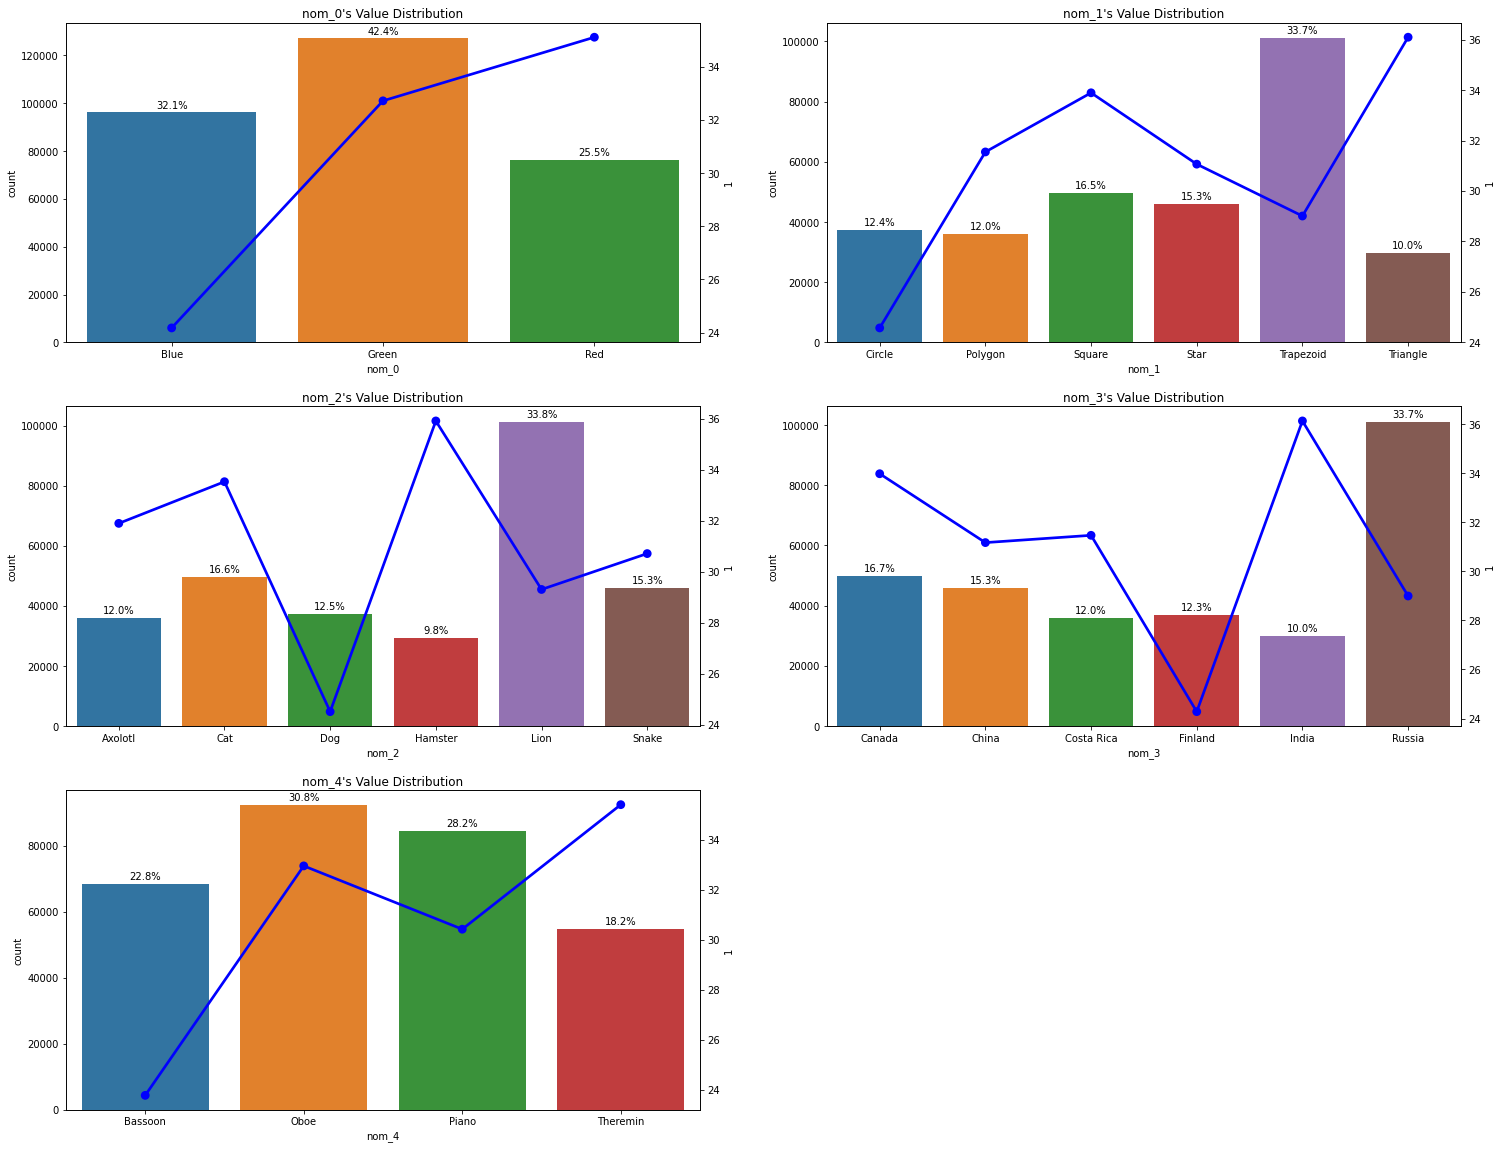

In [47]:
nom_features = [ f'nom_{i}' for i in range(5) ]

def show_count_point_plot( all_data, features, rows=3, cols=2 ):
  # 1개의 차트에 격자로 분할 -> 각 자리에 ax를 전달 -> 이것을 이용하여 그린다
  plt.figure( figsize=(25, 20) ) # 그리면서 조정 : 세로 3칸, 가로 2칸
  # 서브플롯 배치 
  p_grid = gridspec.GridSpec(rows, cols)  # 3줄, 2칸 => 차트 5개 => 피처가 5개

  for idx, feature in enumerate( features ):
    ax = plt.subplot( p_grid[idx] )
    cross_tab = make_cross_tab( all_data, feature )
    # order를 사용 했으면 한차트에 사용되는 모든 함수는 같은 순서(order) 유지 해야 동일하게 배치됨
    sns.countplot( data=all_data, x=feature, ax=ax, order=cross_tab[feature] )  # ax=ax : 격자 안에서 특정 위치로 차트가 세팅
    show_text_percent_by_targert( ax, all_data.shape[0] )
    ax.set_title(f'{ feature }\'s Value Distribution')
    show_pointplot( feature, cross_tab, 'blue', ax.twinx() )
  plt.show()  

show_count_point_plot( train, nom_features )
# 고유값별로 등장 빈도가 다르다 => 학습에 도움이 된다 (구분이 된다)

# 5개의 피처들의 고유값에 정답 1이 차지하는 비율은 전부 다르다 
# => 예측능력이 있다, 학습에 도움이 된다 => 피처들 모두 사용한다

In [27]:
summary_df.loc[ 5:5+9 ]
# 여기 피처는 원-핫 인코딩으로 처리 => CSR 포멧으로 메모리/연산 속도 커버

,feature_name,type,결측치수,고유값수,샘플값0,샘플값1,샘플값2
5,nom_0,object,0,3,Green,Green,Blue
6,nom_1,object,0,6,Triangle,Trapezoid,Trapezoid
7,nom_2,object,0,6,Snake,Hamster,Lion
8,nom_3,object,0,6,Finland,Russia,Russia
9,nom_4,object,0,4,Bassoon,Piano,Theremin
10,nom_5,object,0,222,50f116bcf,b3b4d25d0,3263bdce5
11,nom_6,object,0,522,3ac1b8814,fbcb50fc1,0922e3cb8
12,nom_7,object,0,1220,68f6ad3e9,3b6dd5612,a6a36f527
13,nom_8,object,0,2215,c389000ab,4cd920251,de9c9f684
14,nom_9,object,0,11981,2f4cb3d51,f83c56c21,ae6800dd0


### 순서형 피처 분포

In [50]:
summary_df.iloc[-9:-3]
# ord_0 ~ ord_2 : 정해진순서 (인사이트 적용)
# ord_3 ~ ord_5 : 알파벳순

,feature_name,type,결측치수,고유값수,샘플값0,샘플값1,샘플값2
15,ord_0,int64,0,3,2,1,1
16,ord_1,object,0,5,Grandmaster,Grandmaster,Expert
17,ord_2,object,0,6,Cold,Hot,Lava Hot
18,ord_3,object,0,15,h,a,h
19,ord_4,object,0,26,D,A,R
20,ord_5,object,0,192,kr,bF,Jc


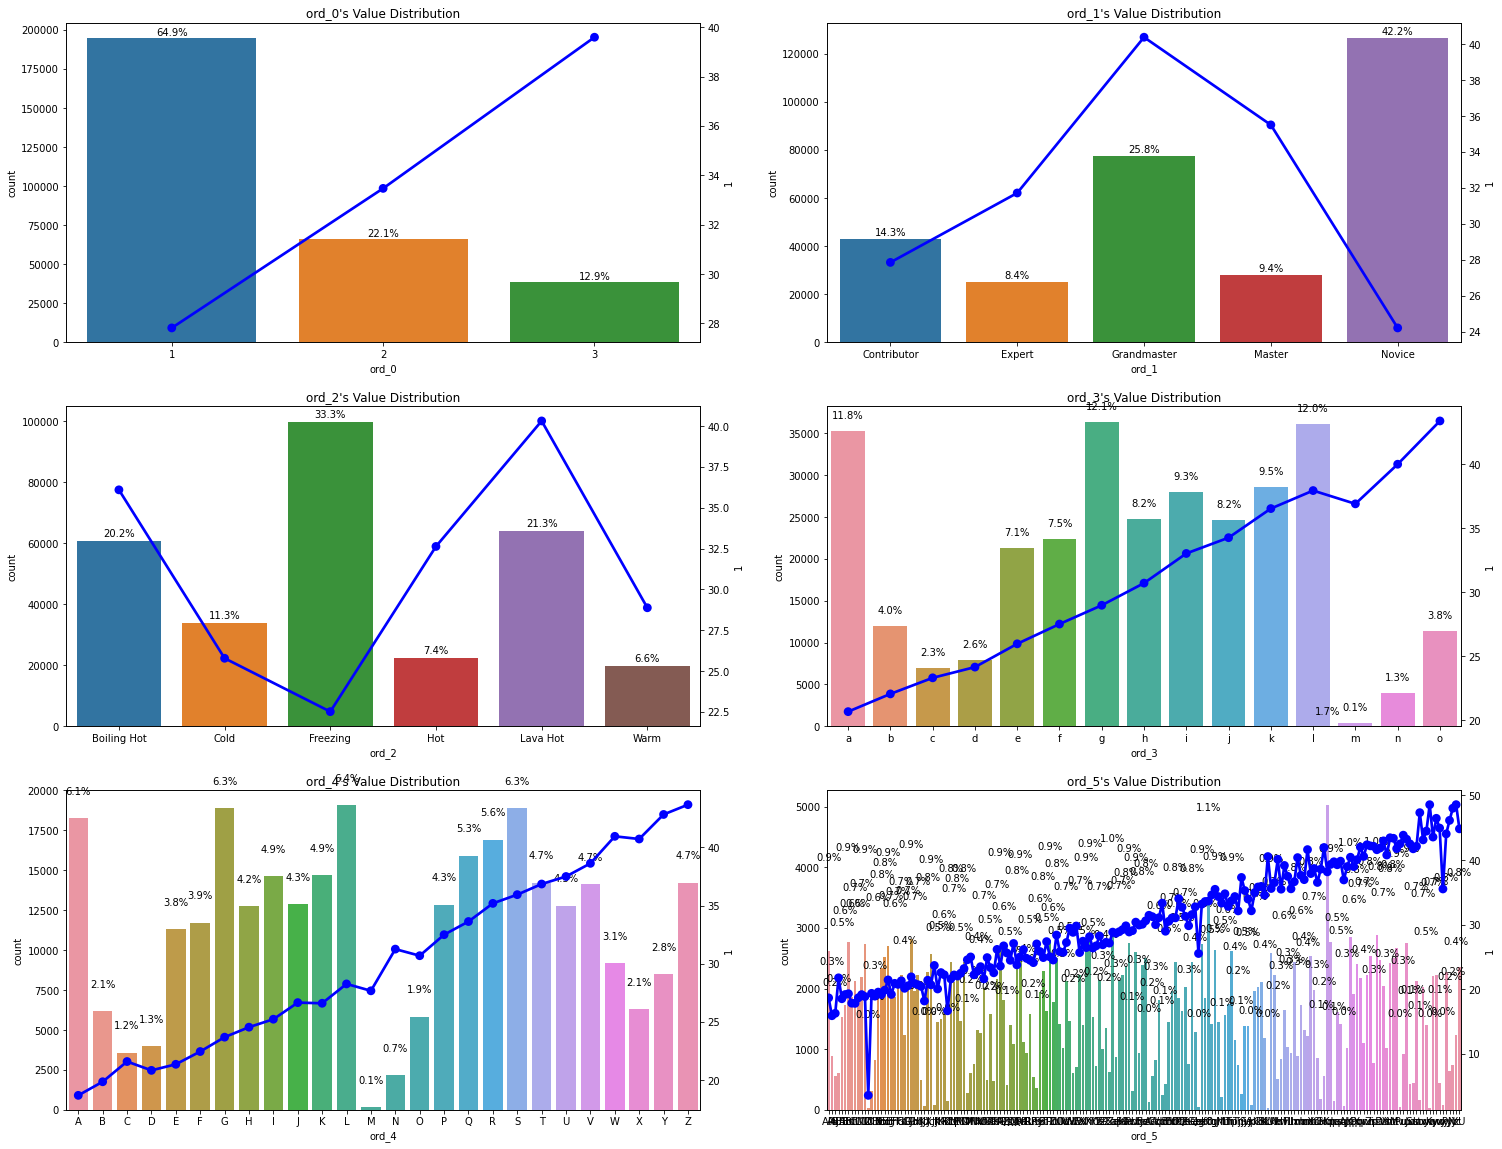

In [53]:
# 일단 시각화
ord_features = [ f'ord_{i}' for i in range(6) ]
show_count_point_plot( train, ord_features, 3, 2 )
# 정답 1에 대힌 비율이 선형을 가르키고 있다 (1차 함수 형태의 직선형 모양)
# 나머지 2개에 순서를 적용하여 최종 시각화 => 모두다 선형을 가르킨다면 => 이 피처는 모두 사용
# -> 이 추세라면 로지스틱회귀가 좋을수도 있겟다!! (베이스라인 모델 )
# 이진 분류 => 로지스틱회귀, svm

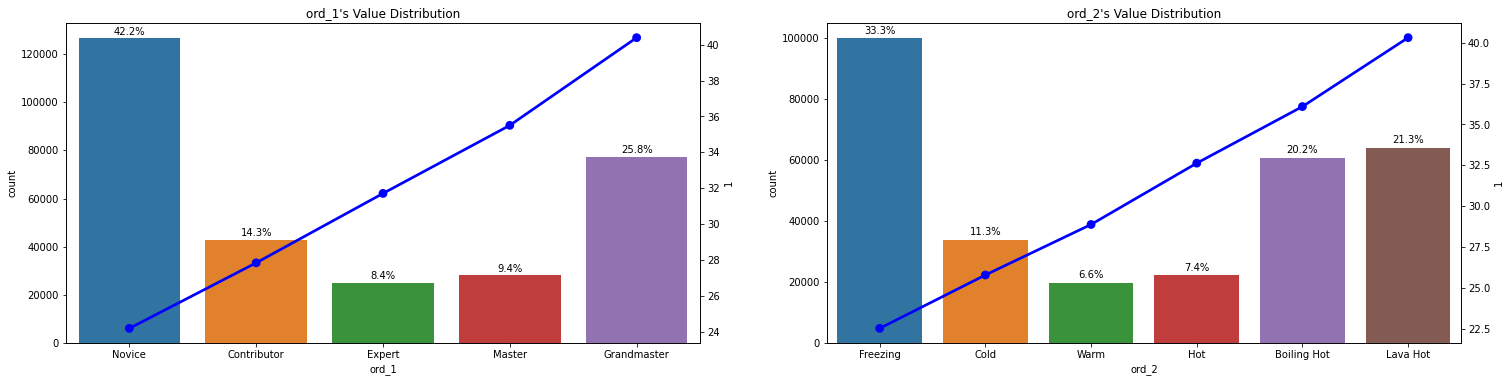

In [59]:
# 피처 순서 지정 처리
from pandas.api.types import CategoricalDtype

# 새로 세팅한 순서
ord_1 = [ 'Novice','Contributor','Expert','Master','Grandmaster' ]
ord_2 = [ 'Freezing','Cold','Warm','Hot','Boiling Hot','Lava Hot' ]

# 순서 생성
ord_1_dtype = CategoricalDtype(ord_1, True)
ord_2_dtype = CategoricalDtype(ord_2, True)

# 순서 적용 -> Dtype 적용
train['ord_1'] = train['ord_1'].astype(ord_1_dtype)
train['ord_2'] = train['ord_2'].astype(ord_2_dtype)

# 시각화
show_count_point_plot( train, ord_features[1:3], 3, 2 )
# 순서형 피처에 고유값에 순서를 정확하게 적용해 보니, 타겟값 1에 대한 비율의 증가가 
# 순서에 맞처서 비례한다는 것을 확인했음

### 날짜(월, 일) 피처 분포

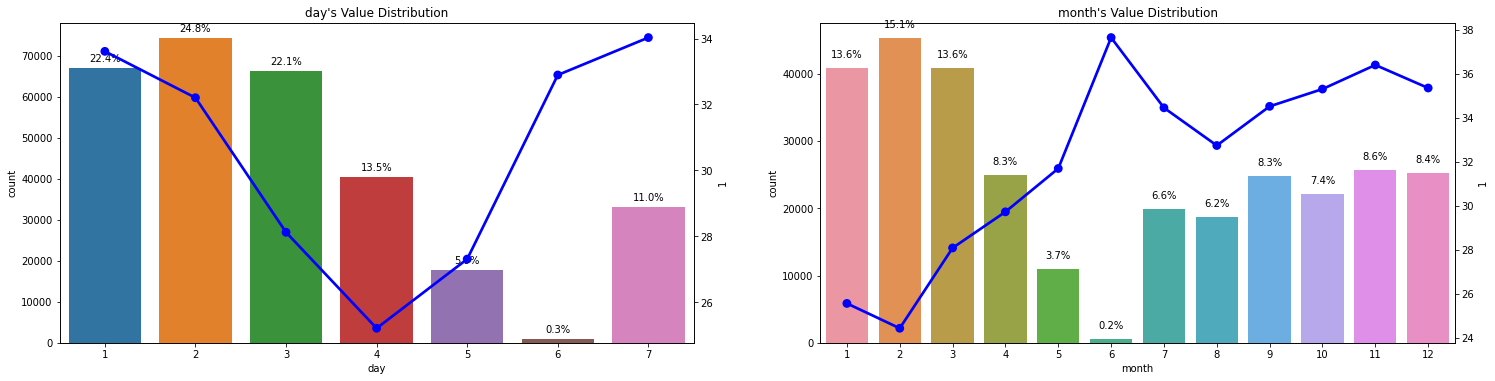

In [60]:
show_count_point_plot( train, ['day','month'] )

# 정석은 순환형(주기형)은 삼각함수 인코딩 
# 여의치 않으면 원-핫 처리 가능 -> 수치에 대한 영향을 제거 가능 -> 19개 피처 생성
# 바의 크기, 타겟 1에 대한 비율은 구분된다 => 학습에 도음은 될듯 -> 피처 유지

## EDA 분석 결과

- bin_xxx
  - 인코딩 전략
    - bin_3, bin_4 은 인코딩(문자->수치) 처리
    - 0, 1로 문자를 변환 처리    
    - 'T':1, 'F':0, 'Y':1, 'N':0  변환 매칭 테이블
    - (통상, 양성, 긍정:P,T,Y => 1, 음성, 부정 => 0으로 매칭)
  - 시각화후 피처 관련 
    - 타겟값 기준 : 2.269
    - bin_0의 고유값별 타겟반 분포 비율 : 2.2733764366019287 2.2413354800440644 :     
    - bin_1, bin_4에서 고유값별 타겟값 비율이 일정 부분 상이한게 보인다 => 정밀 체크 해보야 겟지만 (필요하면 좀더 세부적으로 계산해서 비율을 검토할수 있다)
    - 큰 추세상으로는 다르지 않으므로 그대로 전체 피처를 다 사용하겠다
    - 추세가 많이 다르다면 
      - 해당 피처를 제거하는게 이득인지, 그냥 두고 가는게 이득인지 학습시 조건으로 사용 필요

    - 대부분 피처는 정답 비율을 유지하고 잇지만, 2개 피처는 유지 하지 않고 있다
    -  추세를 벗어난것은 아니다 => 성능을 끌어 올릴대, 3개는 비슷한 유형, 2개는 좀 다른 비율 유형
    - 학습시 성능을 끌어 올릴때 단서 조항 사용

- nom_xxx
  - 고유값 6개 미만은 원-핫 인코딩
  - 고유값이 6개 이상 피처들은 아래 처럼 처리해서 예측 성능 극대화
    - 원-핫 인코딩 단독
    - 피처 제거 기법
    - 해싱 인코딩을 사용 => 비율 축소 혹은 수치 축소
    - 프리퀀시(빈도) 인코딩 사용 => 비중으로 표현
    - 위의 인코딩 방식 + 원-핫 인코딩 조합

- ord_xxx
  - ord_3~5 : 알파벳순 순서 정의
     - OrdinalEncoder
  - ord_0 : 1 -> 2 -> 3
  - ord_1 : Novice -> Contributor -> Expert -> Master -> Grandmaster 
  - ord_2 : Freezing -> Cold -> Warm -> Hot -> Boiling Hot -> Lava Hot
    - map()으로 처리

- day, month
  - day, month 원-핫 인코딩

# 모델 구축

## 피처엔지니어링

- 최종 학습한 데이터 형태 준비
  - 인코딩
  - 스케일링
  - 피처 제거, 파생변수, 결측값 처리, 이상값 제거,..

#### 인코딩

In [61]:
# 현재 데이터
train.shape, test.shape
# 테스트와 훈련용이 75:25 비율이 아니다, 테스트 데이터가 엄청 많다 => 테스트 데이터 최종 
# 예측시 훈련용에 사용이 가능한지도 검토사항
# train와 test 데이터간의 비율이나 특성이 유사한지도 차후 최적화때 검토 사항(점수가 변동없다면 고려)

((300000, 24), (200000, 23))

In [62]:
train.columns

Index(['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1', 'nom_2',
       'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_0',
       'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day', 'month', 'target'],
      dtype='object')

In [69]:
def make_feature_names( prefix_str, size, offset=0  ):
  return [ f'{prefix_str}_{i}' for i in range(offset, size) ]

##### 이진형

- 'bin_3', 'bin_4'
- 'T':1, 'F':0, 'Y':1, 'N':0 변환 매칭 테이블

In [70]:
# 전체 피처
bin_feats = make_feature_names( 'bin', 5 )
# 인코딩 처리할 피처
bin_enc_feats = make_feature_names( 'bin', 5, 3 )
bin_feats, bin_enc_feats

(['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4'], ['bin_3', 'bin_4'])

In [75]:
# 변환 처리 map() => 해당값에 일치되는 키가 발견되면 그 값으로 대체한다
train[ bin_enc_feats[0] ] = train[ bin_enc_feats[0] ].map( {'T':1, 'F':0})
train[ bin_enc_feats[1] ] = train[ bin_enc_feats[1] ].map( {'Y':1, 'N':0})

In [83]:
# 테스트용 데이터 변환
test[ bin_enc_feats[0] ] = test[ bin_enc_feats[0] ].map( {'T':1, 'F':0})
test[ bin_enc_feats[1] ] = test[ bin_enc_feats[1] ].map( {'Y':1, 'N':0})

In [80]:
# 이진 피처 확인 완료!!
tmp = train[ bin_feats ]
summary_feature_info( tmp, tmp )

,feature_name,type,결측치수,고유값수,샘플값0,샘플값1,샘플값2
0,bin_0,int64,0,2,0,0,0
1,bin_1,int64,0,2,0,1,0
2,bin_2,int64,0,2,0,0,0
3,bin_3,int64,0,2,1,1,0
4,bin_4,int64,0,2,1,1,1


##### 명목형

In [81]:
# 2파트로 나눠서 사용
nom_feats = make_feature_names( 'nom', 10 )
print( nom_feats )
tmp = train[ nom_feats ]
summary_feature_info( tmp, tmp )

['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9']


,feature_name,type,결측치수,고유값수,샘플값0,샘플값1,샘플값2
0,nom_0,object,0,3,Green,Green,Blue
1,nom_1,object,0,6,Triangle,Trapezoid,Trapezoid
2,nom_2,object,0,6,Snake,Hamster,Lion
3,nom_3,object,0,6,Finland,Russia,Russia
4,nom_4,object,0,4,Bassoon,Piano,Theremin
5,nom_5,object,0,222,50f116bcf,b3b4d25d0,3263bdce5
6,nom_6,object,0,522,3ac1b8814,fbcb50fc1,0922e3cb8
7,nom_7,object,0,1220,68f6ad3e9,3b6dd5612,a6a36f527
8,nom_8,object,0,2215,c389000ab,4cd920251,de9c9f684
9,nom_9,object,0,11981,2f4cb3d51,f83c56c21,ae6800dd0


###### nom_0 ~ nom_4

  - 고유값 6개 미만은 원-핫 인코딩
    - 원-핫 인코딩 문제점 
      - 희소행렬로 결과가 나온다(대부분이0)<->밀집행렬(대부분이 0이 아닌값)
      - 메모리 낭비가 심함/연산비용증가/학습속도저하
    - 행렬 형식을 변화시켜서 해결
      - COO : coordinate list, 좌표정보로 관리(행,열,값)
      - **CSR : 이 방식이 가장 성능이 좋다**
        - **피처 데이터가 일부분이 이 포멧이 되면, 나머지 데이터도 다 이 포멧으로 변경해서 학습진행**
      - DOK : (행번호,열번호)대 값으로 매핑 관리
      - LIL : 링크드 리스트 알고리즘으로 관리
  - enc_nom_train

In [84]:
# 원핫 인코딩 처리 -> CSR 포멧 -> (300000, 25)
from sklearn.preprocessing import OneHotEncoder

nom_one_hot_feats = make_feature_names( 'nom', 5, 0 )
print( nom_one_hot_feats )

enc_nom_train = OneHotEncoder().fit_transform( train[ nom_one_hot_feats ] )
enc_nom_test = OneHotEncoder().fit_transform( test[ nom_one_hot_feats ] )
enc_nom_train, enc_nom_test

['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4']


(<300000x25 sparse matrix of type '<class 'numpy.float64'>'
 	with 1500000 stored elements in Compressed Sparse Row format>,
 <200000x25 sparse matrix of type '<class 'numpy.float64'>'
 	with 1000000 stored elements in Compressed Sparse Row format>)

###### nom_5 ~ nom_9

  - 고유값이 6개 이상 피처들은 아래 처럼 처리해서 예측 성능 극대화
    - **원-핫 인코딩 단독**
    - 피처 제거 기법
    - **해싱 인코딩**을 사용 => 비율 축소 혹은 수치 축소
    - **프리퀀시(빈도) 인코딩** 사용 => 비중으로 표현
    - 위의 인코딩 방식 + 원-핫 인코딩 조합 (학습후 성과가 않나오면 진행)

###### 원-핫인코딩 - 수정됨

In [184]:
pd.concat( [ train[ nom_etc_feats ], test[ nom_etc_feats ] ] ).shape

(500000, 5)

In [186]:
nom_etc_feats = make_feature_names( 'nom', 5+5, 5 )
print( nom_etc_feats )

# 고유값에 차이가 있어서 수정 
#enc_nom_etc_train = OneHotEncoder().fit_transform( train[ nom_etc_feats ] )
#enc_nom_etc_test = OneHotEncoder().fit_transform( test[ nom_etc_feats ] )

# 원-핫 인코더 생성
alpha_enc = OneHotEncoder()
# 임시 통합 : 테스트와 훈련 사이에 고유값 차이가 있음
temp_alpha = pd.concat( [ train[ nom_etc_feats ], test[ nom_etc_feats ] ] )
# 통합으로 학습
alpha_enc.fit( temp_alpha )
# 개별 변환
enc_nom_etc_train = alpha_enc.transform( train[ nom_etc_feats ]  )
enc_nom_etc_test  = alpha_enc.transform( test[ nom_etc_feats ] )

enc_nom_etc_train, enc_nom_etc_test

# 피처가 많다. 그러나 데이터는 크지 않은편(실제 몇백만 ~ 천만 ~ 억,...)
# 그냥 학습할만 하다 

['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9']


(<300000x16251 sparse matrix of type '<class 'numpy.float64'>'
 	with 1500000 stored elements in Compressed Sparse Row format>,
 <200000x16251 sparse matrix of type '<class 'numpy.float64'>'
 	with 1000000 stored elements in Compressed Sparse Row format>)

###### 해싱처리후 인코딩 -> 로직으로 구현

- 해싱 트릭
  - 데이터 -> 해싱 -> 수치화 -> 특정비율 이하로 처리 -> 데이터 범위가 줄어들고 => 고유값개수도 줄어들것이다 : 해싱을 통해서 그룹화 처리

In [94]:
# 해싱과정 확인
ori_data = '50f116bcf'

# 676039012082104480
# 문자열 => 수치변화 % 기준값 => 값의 범위가 0~ 기준값-1 까지 조정됨
# 기준값의 크기에 따라 중복되는 고유값의 개수를 조정할수 있다
# 다만, 이 피처가 무엇을 의미하는지 몰라서 이 방법이 효과가 있을지는 ?
ori_data, hash(ori_data), hash(ori_data) % 1000

('50f116bcf', 676039012082104480, 480)

In [100]:
STD_RATE = 1000 # 정보 손실을 최소화 하게 구성 => 고유값 개수 조정용

for nom_etc_feat in nom_etc_feats:
  train[ f'{nom_etc_feat}_hash' ] = train[ nom_etc_feat ].apply( lambda x:hash( str(x) ) % STD_RATE )
  test[ f'{nom_etc_feat}_hash' ]  = test[ nom_etc_feat ].apply( lambda x:hash( str(x) ) % STD_RATE )

display( train[ 'nom_5_hash' ] ), display( train[ 'nom_9_hash' ] )

id
0         480
1         447
2         473
3         281
4         350
         ... 
299995    388
299996    110
299997    543
299998    647
299999    678
Name: nom_5_hash, Length: 300000, dtype: int64

id
0         870
1         831
2           0
3         323
4         193
         ... 
299995    746
299996    147
299997    221
299998    857
299999    709
Name: nom_9_hash, Length: 300000, dtype: int64

(None, None)

In [101]:
tmp = train.iloc[ :, -5: ]
summary_feature_info( tmp, tmp )
# 고유값의 개수가 기준 16천여개 => 32백여개로 조정되었다 : 원-핫 인코딩처리시 저용량의 데이터 조정

,feature_name,type,결측치수,고유값수,샘플값0,샘플값1,샘플값2
0,nom_5_hash,int64,0,196,480,447,473
1,nom_6_hash,int64,0,413,854,967,483
2,nom_7_hash,int64,0,713,685,133,805
3,nom_8_hash,int64,0,905,703,784,778
4,nom_9_hash,int64,0,1000,870,831,0


###### 프리퀀시(빈도) 인코딩 -> 로직으로 구현

- 고유값의 등장 빈도 ->빈도가 높다 -> 자주 노출되는 값이다 -> 중요값, 대표값, 영향력이 높다 -> 아이디어를 기반으로 데이터를 재구성
- 고유값별 빈도수 -> 게산 => 해당 고유값대시 배치 -> 명목형의 의미가 퇴색됨

In [105]:
# 전체 빈도 대비 개별 고유값의 빈도값 => 활성화함수 softamx() => 다중 분류의 개별값 확률 계산식
np.sum( train.groupby('nom_5').size().values / len(train) )

# train[ 'nom_5_freq' ]  nom_5 ~ 9 번까지 계산하여 생성하시오

1.0

In [110]:
tmp = train.groupby('nom_5').size() / len(train)
tmp, tmp['005dd4ce3']

(nom_5
 005dd4ce3    0.000903
 037bd73d8    0.004677
 05950689f    0.006620
 05d5943a3    0.001903
 06eeaf0aa    0.009167
                ...   
 f8faea16f    0.004613
 f9d17bb93    0.004867
 f9e5266f9    0.002937
 fa0a88fe9    0.002420
 fd04a970f    0.005120
 Length: 222, dtype: float64, 0.0009033333333333334)

In [112]:
for nom_etc_feat in nom_etc_feats:
  print( f'{nom_etc_feat}_freq', nom_etc_feat )

  tmp = train.groupby( nom_etc_feat ).size() / len(train)
  train[ f'{nom_etc_feat}_freq' ] = train[nom_etc_feat].apply( lambda x : tmp[x] )

  tmp = test.groupby( nom_etc_feat ).size() / len(test)
  test[ f'{nom_etc_feat}_freq' ]  = test[nom_etc_feat].apply( lambda x : tmp[x] )

  # 서열을 부여하면다면 의미 있는 내용이 나올수도 있을듯 -> 원-핫을 하면 이 정보가 사라짐

tmp = train.iloc[ :, -5: ]
summary_feature_info( tmp, tmp )

nom_5_freq nom_5
nom_6_freq nom_6
nom_7_freq nom_7
nom_8_freq nom_8
nom_9_freq nom_9


,feature_name,type,결측치수,고유값수,샘플값0,샘플값1,샘플값2
0,nom_5_freq,float64,0,216,0.008647,0.002640,0.008413
1,nom_6_freq,float64,0,422,0.003827,0.002807,0.003897
2,nom_7_freq,float64,0,468,0.000803,0.000957,0.001583
3,nom_8_freq,float64,0,290,0.000903,0.000370,0.000927
4,nom_9_freq,float64,0,69,0.000063,0.000043,0.000097


##### 순서형

###### ord_1~2 


- map을 이용하여 기본 변경 

In [67]:
ord_feats = make_feature_names( 'ord', 6 )
ord_feats

['ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5']

In [167]:
ord_1_dict = { 'Novice':0,'Contributor':1,'Expert':2,'Master':3, 'Grandmaster':4 }
ord_2_dict = { 'Freezing':0,'Cold':1,'Warm':2,'Hot':3,'Boiling Hot':4,'Lava Hot':5 }

train['ord_1'] = train.copy()['ord_1'].map( ord_1_dict )
train['ord_2'] = train.copy()['ord_2'].map( ord_2_dict )

test['ord_1'] = test2.copy()['ord_1'].map( ord_1_dict )
test['ord_2'] = test2.copy()['ord_2'].map( ord_2_dict )

tmp = train[ ord_feats[1:3] ]
summary_feature_info( tmp, tmp )

,feature_name,type,결측치수,고유값수,샘플값0,샘플값1,샘플값2
0,ord_1,int64,0,5,4,4,2
1,ord_2,int64,0,6,1,3,5


###### ord_3 ~ 5

- 순서형 인코더 활용 (고유값 데이터가 많은 경우)

In [117]:
from sklearn.preprocessing import OrdinalEncoder

ori_enc = OrdinalEncoder()
ori_enc.fit( train[ ord_feats[-3:] ] )

OrdinalEncoder()

In [118]:
# 순서 확인
ori_enc.categories_

[array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
        'n', 'o'], dtype=object),
 array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
        'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'],
       dtype=object),
 array(['AP', 'Ai', 'Aj', 'BA', 'BE', 'Bb', 'Bd', 'Bn', 'CL', 'CM', 'CU',
        'CZ', 'Cl', 'DH', 'DN', 'Dc', 'Dx', 'Ed', 'Eg', 'Er', 'FI', 'Fd',
        'Fo', 'GD', 'GJ', 'Gb', 'Gx', 'Hj', 'IK', 'Id', 'JX', 'Jc', 'Jf',
        'Jt', 'KR', 'KZ', 'Kf', 'Kq', 'LE', 'MC', 'MO', 'MV', 'Mf', 'Ml',
        'Mx', 'NV', 'Nf', 'Nk', 'OR', 'Ob', 'Os', 'PA', 'PQ', 'PZ', 'Ps',
        'QM', 'Qb', 'Qh', 'Qo', 'RG', 'RL', 'RP', 'Rm', 'Ry', 'SB', 'Sc',
        'TR', 'TZ', 'To', 'UO', 'Uk', 'Uu', 'Vf', 'Vx', 'WE', 'Wc', 'Wv',
        'XI', 'Xh', 'Xi', 'YC', 'Yb', 'Ye', 'ZR', 'ZS', 'Zc', 'Zq', 'aF',
        'aM', 'aO', 'aP', 'ac', 'av', 'bF', 'bJ', 'be', 'cA', 'cG', 'cW',
        'ck', 'cp', 'dB', 'dE', 'dN', 'dO', 'dP', 'dQ', 'd

In [119]:
train[ ord_feats[-3:] ] = ori_enc.transform( train[ ord_feats[-3:] ] )

# 순서대로 수치로 변경되었다 -> 머신러닝이 이웃한 숫자에대 더 가깞다고 느껴도 ok
tmp = train[ ord_feats[-3:] ]
summary_feature_info( tmp, tmp )

,feature_name,type,결측치수,고유값수,샘플값0,샘플값1,샘플값2
0,ord_3,float64,0,15,7.0,0.0,7.0
1,ord_4,float64,0,26,3.0,0.0,17.0
2,ord_5,float64,0,192,136.0,93.0,31.0


In [123]:
# 테스트 데이터
test[ ord_feats[-3:] ] = OrdinalEncoder().fit_transform( test[ ord_feats[-3:] ] )

##### 날짜(순환형)형

- 원-핫 인코딩

In [124]:
date_feats = ['day','month']
enc_date_train = OneHotEncoder().fit_transform( train[ date_feats ] )
enc_date_test  = OneHotEncoder().fit_transform( test[  date_feats ] )

# (300000, 19) (200000, 19)
enc_date_train, enc_date_test

(<300000x19 sparse matrix of type '<class 'numpy.float64'>'
 	with 600000 stored elements in Compressed Sparse Row format>,
 <200000x19 sparse matrix of type '<class 'numpy.float64'>'
 	with 400000 stored elements in Compressed Sparse Row format>)

#### 피처 스케일링

- 이진 피처 : 0, 1 => 대상아님

- 순서 피처

In [126]:
ord_train_sample = train[ ord_feats ]
summary_feature_info( ord_train_sample, ord_train_sample )
# 관찰 결과 스케이링 필요 => 차후 cv 를 사용한다면 파이프라인에서 스케일러 지정
# 여기서는 베이스라이 모델에 맞춰서 진행, MinMaxScaler

ord_train_sample

,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5
id,,,,,,
0,2,4,1,7.0,3.0,136.0
1,1,4,3,0.0,0.0,93.0
2,1,2,5,7.0,17.0,31.0
3,1,4,4,8.0,3.0,134.0
4,1,4,0,0.0,17.0,158.0
...,...,...,...,...,...,...
299995,1,1,0,10.0,10.0,108.0
299996,2,0,0,7.0,22.0,40.0
299997,3,0,4,14.0,0.0,7.0


In [129]:
from sklearn.preprocessing import MinMaxScaler

ord_train_sample[ ord_feats ] = MinMaxScaler().fit_transform( ord_train_sample[ ord_feats ] )
ord_train_sample

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5
id,,,,,,
0,0.5,1.00,0.2,0.500000,0.12,0.712042
1,0.0,1.00,0.6,0.000000,0.00,0.486911
2,0.0,0.50,1.0,0.500000,0.68,0.162304
3,0.0,1.00,0.8,0.571429,0.12,0.701571
4,0.0,1.00,0.0,0.000000,0.68,0.827225
...,...,...,...,...,...,...
299995,0.0,0.25,0.0,0.714286,0.40,0.565445
299996,0.5,0.00,0.0,0.500000,0.88,0.209424
299997,1.0,0.00,0.8,1.000000,0.00,0.036649


In [179]:
ord_test_sample = test[ ord_feats ]
#ord_test_sample.shape
ord_test_sample[ ord_feats ] = MinMaxScaler().fit_transform( ord_test_sample[ ord_feats ] )
ord_test_sample.shape

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


(200000, 6)

In [158]:
ord_test_sample

,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5
id,,,,,,
300000,0.5,NaN,NaN,0.642857,0.60,0.497382
300001,0.0,NaN,NaN,0.785714,0.00,0.319372
300002,0.5,NaN,NaN,0.000000,0.24,0.900524
300003,0.0,NaN,NaN,0.071429,0.64,0.706806
300004,1.0,NaN,NaN,0.785714,0.88,0.821990
...,...,...,...,...,...,...
499995,0.0,NaN,NaN,0.642857,0.00,0.130890
499996,0.0,NaN,NaN,0.357143,0.72,0.089005
499997,0.0,NaN,NaN,0.428571,0.84,0.345550


- 명목형

In [131]:
# 고유값 6개 이하 피처만 모아서 원-핫 처리
enc_nom_train

<300000x25 sparse matrix of type '<class 'numpy.float64'>'
	with 1500000 stored elements in Compressed Sparse Row format>

In [134]:
# 피처가 많은 대상 => enc_nom_etc_train, 해싱, 빈도
enc_nom_etc_train

<300000x16160 sparse matrix of type '<class 'numpy.float64'>'
	with 1500000 stored elements in Compressed Sparse Row format>

- 날짜형

In [135]:
enc_date_train

<300000x19 sparse matrix of type '<class 'numpy.float64'>'
	with 600000 stored elements in Compressed Sparse Row format>

#### 데이터 병합(포멧 맞춰서, CSR)

- df 의 데이터와 CSR 데이터가 합병 => CSR로 합병

In [140]:
train[ bin_features ].shape, ord_train_sample.shape

((300000, 5), (300000, 6))

In [187]:
from scipy import sparse

final_train_data_csr = sparse.hstack( [
    sparse.csc_matrix(train[ bin_features ]), # bin 피처 (300000, 5), df
    enc_nom_train,         # nom_0~4, CSR (300000x25)
    enc_nom_etc_train,     # nom_5~9, CSR (300000x16160)
    sparse.csc_matrix(ord_train_sample),      # ord_0~5, df (300000, 6)
    enc_date_train         # day, month, CSR (300000x19)
], format='csr')

final_train_data_csr

<300000x16306 sparse matrix of type '<class 'numpy.float64'>'
	with 5497975 stored elements in Compressed Sparse Row format>

- 만약, 훈련용, 테스트용 데이터를 합병하고 피처엔지니어링을 햇다면, 여기서 분리
- train_test_split() 이것도 여기서 부터 사용 가능

## 베이스라인 구축

- 성능 신경않쓰고, 제출까지 진행
  - 하나의 파이프라인 구축(전체 공정)

In [188]:
# 데이터 분리 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

X = final_train_data_csr
y = train['target']

# 테스트 데이터 비율을 조절하거나, 차후 제거하는것까지 검토 -> 성능향상을 위해서 
X_train, X_test, y_train, y_test = train_test_split(  X, y, 
                                                     test_size=0.15, stratify=y, random_state=0 )

X_train.shape, X_test.shape, y_train.shape, y_test.shape

# 알고리즘선정 - 하이퍼파라미터 - cv - 학습 - 예측및 성능평가
# 이진분류, 선형모델을 내부적으로 가지고, 피처가 많아도 학습 속도가 빠르 로지스틱회귀 처리
clf = LogisticRegression()

# 하이퍼파라미터
clf_params = {
    'C':[0.001, 0.01, 0.1, 1, ],   # 규제강도, 높을수록 강함, -> L1, L2가 적용시 규제 강도를 강화
    'max_iter':[500, 750, 1000],   #  모델 성능을 오리기 위해서 학습의 반복 횟수 제한
    'solver':['liblinear'],        # 과정합 방지용 지표 L1, L2 를 모두 지원 -> 방식
    'random_state':[100],          # 난수 시드
}

# 그리드서치 CV -> 최적 파라미터 획득
clf_model = GridSearchCV(clf, clf_params, scoring='roc_auc', cv=5)

# 훈련
clf_model.fit( X_train, y_train )

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1],
                         'max_iter': [500, 750, 1000], 'random_state': [100],
                         'solver': ['liblinear']},
             scoring='roc_auc')

In [189]:
clf_model.best_params_, clf_model.best_score_

({'C': 0.1, 'max_iter': 500, 'random_state': 100, 'solver': 'liblinear'},
 0.8027687785672564)

### 모델 성능 테스트 추가코드

In [195]:
from sklearn.metrics import roc_auc_score
# 모델 성능 테스트 
y_pred_test = clf_model.best_estimator_.predict_proba( X_test )[:, 1]

roc_auc_score(y_test, y_pred_test)

0.8251150102357887

In [190]:
# 제출 파일 생성
# 테스트데이터 -> 예측 -> 1에 대한 확률을 획득 -> 제출파일 df에 세팅 -> 파일로 저장
final_train_data_csr

<300000x16306 sparse matrix of type '<class 'numpy.float64'>'
	with 5497975 stored elements in Compressed Sparse Row format>

In [154]:
enc_nom_etc_test

<200000x16016 sparse matrix of type '<class 'numpy.float64'>'
	with 1000000 stored elements in Compressed Sparse Row format>

In [ ]:
enc_nom_etc_train,     # nom_5~9, CSR (300000x16160)
enc_nom_etc_test,     # nom_5~9, CSR (200000x16016 )

In [191]:
# 테스트데이터 구성
final_test_data_csr = sparse.hstack( [
    sparse.csc_matrix(test[ bin_features ]), # bin 피처 (200000, 5), df
    enc_nom_test,         # nom_0~4, CSR (200000x25)
    enc_nom_etc_test,     # nom_5~9, CSR (200000x16016 )
    sparse.csc_matrix(ord_test_sample),      # ord_0~5, df (200000, 6)
    enc_date_test         # day, month, CSR (200000x19)
], format='csr')
final_test_data_csr

<200000x16306 sparse matrix of type '<class 'numpy.float64'>'
	with 3665743 stored elements in Compressed Sparse Row format>

In [182]:
final_test_data_csr

<200000x16071 sparse matrix of type '<class 'numpy.float64'>'
	with 3665743 stored elements in Compressed Sparse Row format>

In [192]:
# 타깃값 1일 확률 예측
y_pred = clf_model.best_estimator_.predict_proba( final_test_data_csr )[:, 1]
# 파일 저장
submission['target'] = y_pred
submission.to_csv('submission_ver1.csv')

In [162]:
submission.head(1)

,target
id,
300000,0.5


## 최적 알고리즘 선정

- 하이퍼파라미터튜닝 + 교차검증 + 파이프라인 구축 -> 선정 (예측 정확도를 시각화해서, 박스플롯 활용)

### CV 대비 데이터 split

## 선정된 알고리즘의 최적화 진행


- 좀더 성능을 높이기 위한 조치 진행

In [194]:
# 데이터 분리 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

X = final_train_data_csr
y = train['target']

clf = LogisticRegression(C=0.1,max_iter=500, random_state=100, solver='liblinear')
clf_model.fit( X, y )

# 타깃값 1일 확률 예측
y_pred = clf_model.best_estimator_.predict_proba( final_test_data_csr )[:, 1]
# 파일 저장
submission['target'] = y_pred
submission.to_csv('submission_ver2.csv')

# 예측 결과 제출

- 캐글에 제출해서 score 확인